# Ablation: Semi-Supervised Architope - for Reviews
---
- This code Implements Algorithm 3.2 of the "PC-NNs" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = 1-(1/24)
min_width = 100
min_epochs = 100
# Ablation Finess
N_plot_finess = 5
# min_parts_threshold = .001; max_parts_threshold = 0.9
N_min_parts = 1; N_max_plots = 5
Tied_Neurons_Q = True
# Partition with Inputs (determine parts with domain) or outputs (determine parts with image)
Partition_using_Inputs = True
# Cuttoff Level
gamma = .5
# Softmax Layer instead of sigmoid
softmax_layer = False #<- Just out of curiosity...but it doesn't perform many better IRL

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 10**4

def f_1(x):
    return x
def f_2(x):
    return np.exp(-x)
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
1
Training Data size:  416


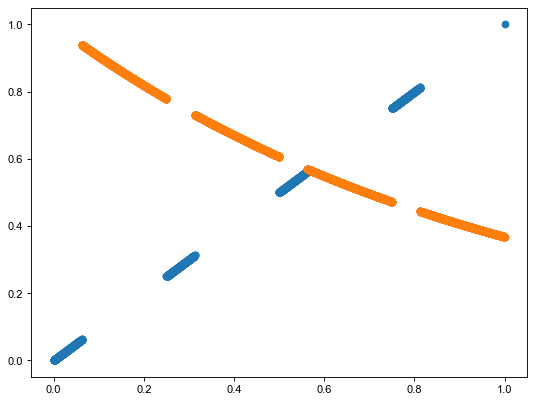

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# exec(open('Prepare_Data_California_Housing.py').read())
# Import time separately
import time

# TEMP
# import pickle_compat
# pickle_compat.patch()
# param_grid_Vanilla_Nets['input_dim']=X_train.shape[1]
sns.set()
plt.show()


### Set Seed

In [6]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

#### Explicit Partion Builder:
Implements exactly Algorithm 2:

In [7]:
def Random_Lipschitz_Partioner(X_in,
                               y_in,
                               N_parts_to_get=4):

    # Compute Size of each part
    size_part_reference = int(round(X_in.shape[0]/N_parts_to_get))

    # Apply random bijection #
    #------------------------#
    ## Get random bijection indices
    random_bijection_indices = np.random.choice(range(X_in.shape[0]),size=X_in.shape[0], replace=False)
    ## Apply random bijections
    X_in_shuffled = X_in[random_bijection_indices,:]
    y_in_shuffled = y_in[random_bijection_indices,:]

    # Initialize Lists #
    #------------------#
    X_parts = []
    y_parts = []

    for i_th_part_to_get in range(N_parts_to_get):
        # Build random balls #
        #--------------------#
        ## Sample random radius
        size_part = int(np.maximum(1,np.round(size_part_reference*np.random.uniform(low=.5,high=1.5,size=1)[0])))
        ## Sample random point
        X_center_loop_index = np.random.choice(range(X_in_shuffled.shape[0]),size=1, replace=False)
        X_center_loop = X_in_shuffled[X_center_loop_index,:]
        ## Compute Typical Distances from Center
        distances_loop = X_center_loop-X_in_shuffled
        distances_loop = np.linalg.norm(distances_loop, axis=1)

        # Remove Random Ball from Dataset
        if size_part <= len(distances_loop):
            ## Identify indices
            indices_smallest_to_random_ball = np.argsort(distances_loop)[:size_part]
        else:
            print('Final Loop')
            indices_smallest_to_random_ball = np.array(range(X_in_shuffled.shape[0]))
        ## Extract Parts
        X_current_part_loop = X_in_shuffled[indices_smallest_to_random_ball,:]
        y_current_part_loop = y_in_shuffled[indices_smallest_to_random_ball,:]
        ## Append to List of Parts
        X_parts.append(X_current_part_loop)
        y_parts.append(y_current_part_loop)

        # Remove Selected Entries From Array #
        #------------------------------------#
        X_in_shuffled = np.delete(X_in_shuffled,indices_smallest_to_random_ball,axis=0)
        y_in_shuffled = np.delete(y_in_shuffled,indices_smallest_to_random_ball,axis=0)

        # Failsafe if procedure has terminated
        if X_in_shuffled.shape[0] == 0:
            print('breaking early')
            break
    # Count Number of Parts Generated        
    N_parts_generated = len(X_parts)
    # Output Parts
    return X_parts, y_parts, N_parts_generated

# Ablation Function

In [8]:
def get_PCNNs(N_parts,X_train,y_train,X_test,y_test):

    # Initialization(s) #
    #-------------------#
    N_neurons = 0
    L_timer = 0
    P_timer = 0
    Mean_Width_Subnetworks = 0

    # Partitioner Begin #
    #-------------------#
    import time
    partitioning_time_begin = time.time()
    print('-------------------------------------------------------')
    print('Randomly Initialized Parts - Via Randomized Algorithm 2')
    print('-------------------------------------------------------')
    if Partition_using_Inputs == True:
        X_parts_list, y_parts_list, N_parts_Generated_by_Algo_2 = Random_Lipschitz_Partioner(X_train.to_numpy(),
                                                                                             y_train.reshape(-1,1),
                                                                                             N_parts)
    else:
        X_parts_list, y_parts_list, N_parts_Generated_by_Algo_2 = Random_Lipschitz_Partioner(y_train.reshape(-1,1),
                                                                                             X_train.to_numpy(),
                                                                                             N_parts)
    partitioning_time = time.time() - partitioning_time_begin
    print('The_parts_listhe number of parts are: ' + str(N_parts_Generated_by_Algo_2)+'.')
    ############# Partitioner End ########

    print('-----------------------------------------------------')
    print('Training Sub-Networks on Each Randomly Generated Part')
    print('-----------------------------------------------------')
    # Time-Elapse (Start) for Training on Each Part #
    PCNN_timer = time.time(); PCNN_timer = -math.inf; N_params_Architope = 0; N_params_tally = 0
    # Remove Eager Execution Error(s)
    tf.compat.v1.disable_eager_execution()
    # Automatically Initialize Correct Input/Output Dimension(s)
    param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]; param_grid_Vanilla_Nets['output_dim'] = [1]
    param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
    # Decide if/or not to tie neuron numbers of sub-patterns together
    if Tied_Neurons_Q == True:
        param_grid_Vanilla_Nets['height'] = [int(np.maximum(round(param_grid_Vanilla_Nets['height'][0]/N_parts),min_width))]
        param_grid_Vanilla_Nets['epochs'] = [int(np.maximum(round(param_grid_Vanilla_Nets['epochs'][0]/int(round(np.sqrt(N_parts)))),min_epochs))]
#         param_grid_Deep_Classifier['height'] = [int(np.maximum(round(param_grid_Deep_Classifier['height'][0]/N_parts),min_width))]

    for current_part in range(N_parts_Generated_by_Algo_2):
        # Update User #
        #-------------#
        print('-----------------------------------------------------------')
        print('Currently Training Part: '+str(current_part)+'/'+str(N_parts_Generated_by_Algo_2 )+'Total Parts.')
        print('-----------------------------------------------------------')

        # Timer for Part
        part_training_timer = time.time()
        # Get Data for Sub-Pattern
        X_loop = pd.DataFrame(X_parts_list[current_part])
        y_loop = (y_parts_list[current_part]).reshape(-1,)
        # Train ffNN
        y_hat_part_loop, y_hat_part_loop_test, N_neurons_PCNN_loop = build_ffNN(n_folds = 4, 
                                                                              n_jobs = n_jobs,
                                                                              n_iter = n_iter, 
                                                                              param_grid_in = param_grid_Vanilla_Nets, 
                                                                              X_train= X_loop, 
                                                                              y_train=y_loop,
                                                                              X_test_partial=X_train,
                                                                              X_test=X_test,
                                                                              NOCV=True)
        # Reshape y
        ## Training
        y_train.shape = (y_train.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop.shape = (y_hat_part_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        ## Testing
        y_test.shape = (y_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop_test.shape = (y_hat_part_loop_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])

        # Append predictions to data-frames
        ## If first prediction we initialize data-frames
        if current_part==0:
            # Register quality
            training_quality = np.array(np.abs(y_hat_part_loop-y_train)).reshape(y_hat_part_loop.shape[0],1)

            # Save Predictions
            predictions_train = y_hat_part_loop.reshape(y_hat_part_loop.shape[0],1)
            predictions_test = y_hat_part_loop_test.reshape(y_hat_part_loop_test.shape[0],1)


        ## If not first prediction we append to already initialized dataframes
        else:
        # Register Best Scores
            #----------------------#
            # Write Predictions 
            # Save Predictions
            y_hat_train_loop = y_hat_part_loop.reshape(predictions_train.shape[0],1)
            predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
            y_hat_test_loop = y_hat_part_loop_test.reshape(predictions_test.shape[0],1)
            predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)

            # Evaluate Errors #
            #-----------------#
            # Training
            prediction_errors = np.abs(y_hat_train_loop-y_train)
            training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)

        #==============================#
        # Update Performance Metric(s) #
        #==============================#
        part_training_timer = time.time() - part_training_timer
        # L-Time
        L_timer += partitioning_time
        # P-Time
        P_timer = max(P_timer,part_training_timer)
        # N. Params
        N_neurons += N_neurons_PCNN_loop
        # Mean Width for Sub-Network(s)
        Mean_Width_Subnetworks += param_grid_Vanilla_Nets['height'][0]

    # Take Mean of Width(s)
    Mean_Width_Subnetworks = Mean_Width_Subnetworks/N_parts_Generated_by_Algo_2
    print('-----------------------')
    print('Training Deep Zero-Sets')
    print('-----------------------')


    # Time Elapsed for Training Deep Zero-Sets
    Deep_Zero_Sets_timer = time.time()

    ## Initialize Classes Labels
    if softmax_layer == False:
        # No pooling (classical)
        partition_labels_training_integers = np.argmin(training_quality,axis=-1)
    else:
        # Max Pooling
#         partition_labels_training_integers = (training_quality == training_quality.min(axis=1)[:,None]).astype(int)
        partition_labels_training_integers = np.apply_along_axis(softminn, 1, training_quality).astype(int)
    partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
    ## Build Classes
    for part_column_i in range(1,(training_quality.shape[1])):
        partition_labels_training = pd.concat([partition_labels_training,
                                               (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                              ],axis=1)
    ## Convert to integers
    partition_labels_training = partition_labels_training+0
    ## Train simple deep classifier
    tf.compat.v1.disable_eager_execution()
    predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train.values, 
                                                                                                        y_train = partition_labels_training.values,
                                                                                                        X_test = X_test.values)
    # Get Binary Classes (Discontinuous Unit)
    ## Training Set
    predicted_classes_train = ((predicted_classes_train>gamma)*1).astype(int)
    ## Testing Set
    predicted_classes_test = ((predicted_classes_test > gamma)*1).astype(int)
    # Get PC-NN Prediction(s)
    ## Train
    PCNN_prediction_y_train = (predictions_train*predicted_classes_train).sum(axis=1)
    ## Test
    PCNN_prediction_y_test = (predictions_test*predicted_classes_test).sum(axis=1)

    # End Timer
    Deep_Zero_Sets_timer = time.time() - Deep_Zero_Sets_timer

    print('-----------------------------------')
    print('Computing Final Performance Metrics')
    print('-----------------------------------')
    # Time-Elapsed Training Deep Classifier

    # Update Times
    L_timer +=Deep_Zero_Sets_timer
    P_timer +=Deep_Zero_Sets_timer
    # Update Number of Neurons Used
    N_neurons_subPatterns = N_neurons
    N_neurons_deep_Zero_Sets = (param_grid_Deep_Classifier['height'][0])*(param_grid_Deep_Classifier['depth'][0])
    N_neurons = N_neurons_deep_Zero_Sets + N_neurons_subPatterns



    # Compute Peformance
    performance_PCNN = reporter(y_train_hat_in=PCNN_prediction_y_train,y_test_hat_in=PCNN_prediction_y_test,
                                y_train_in=y_train,
                                y_test_in=y_test)
    # Write Performance
    performance_PCNN.to_latex((results_tables_path+"PCNN_full_performance.tex"))

    # Update User
    print(performance_PCNN)

    ### Model Complexity/Efficiency Metrics
    # Build AIC-like Metric #
    #-----------------------#
    AIC_like = 2*(N_neurons - np.log((performance_PCNN['test']['MAE'])))
    AIC_like = np.round(AIC_like,3)
    Efficiency = np.log(N_neurons) *(performance_PCNN['test']['MAE'])
    Efficiency = np.round(Efficiency,3)


    # Build Table #
    #-------------#
    PCNN_Model_Complexity = pd.DataFrame({'L-time': [L_timer],
                                               'P-time':[P_timer],
                                               'N_params_expt': [N_neurons],
                                               'AIC-like': [AIC_like],
                                               'Eff': [Efficiency],
                                               'N. Parts':[N_parts_Generated_by_Algo_2]})


    # Write Required Training Time(s)
    PCNN_Model_Complexity.to_latex((results_tables_path+"PCNN_full_model_complexities.tex"))

    #--------------======---------------#
    # Display Required Training Time(s) #
    #--------------======---------------#
    print(PCNN_Model_Complexity)
    
    
    
    #########################################
    for j in range(10):
        print('#------------------------------#')
    #########################################
    print('# ---- Getting Benchmarks ---- #')
    #########################################
    for j in range(10):
        print('#------------------------------#')
    #########################################
    print('Training PCNN-lgt')
    # Time-Elapsed Training linear classifier
    Architope_logistic_classifier_training_begin = time.time()
    if N_parts > 1:
        parameters = {'penalty': ['none'], 'C': [0.1]}
        lr = LogisticRegression(random_state=2020)
        cv = RepeatedStratifiedKFold(n_splits=CV_folds, 
                                     n_repeats=n_iter, random_state=0)
        classifier = RandomizedSearchCV(lr, 
                                        parameters, 
                                        random_state=2020)

        # Initialize Classes Labels
        partition_labels_training = np.argmin(training_quality,axis=-1)
        # Train Logistic Classifier #
        #---------------------------#
        # Supress warnings caused by "ignoring C" for 'none' penalty and similar obvious warnings
        warnings.simplefilter("ignore")
        # Train Classifier
        classifier.fit(X_train, partition_labels_training)
    if N_parts >1 :
        #### Write Predicted Class(es)
        # Training Set
        predicted_classes_train_logistic_BM = classifier.best_estimator_.predict(X_train)
        Architope_prediction_y_train_logistic_BM = np.take_along_axis(predictions_train, predicted_classes_train_logistic_BM[:,None], axis=1)
        # Testing Set
        predicted_classes_test_logistic_BM = classifier.best_estimator_.predict(X_test)
        Architope_prediction_y_test_logistic_BM = np.take_along_axis(predictions_test, 
                                                                     predicted_classes_test_logistic_BM[:,None], 
                                                                     axis=1)
    else:
        #### Write Predicted Class(es)
        # Training Set
        Architope_prediction_y_train_logistic_BM = predictions_train
        # Testing Set
        Architope_prediction_y_test_logistic_BM = predictions_test    
    # Extract Number of Parameters Logistic Regressor
    if N_parts > 1:
        N_params_best_logistic = (classifier.best_estimator_.coef_.shape[0])*(classifier.best_estimator_.coef_.shape[1]) + len(classifier.best_estimator_.intercept_)
    else:
        N_params_best_logistic = 1
    N_params_best_logistic = N_params_best_logistic + N_neurons_subPatterns*N_parts    
    # Time-Elapsed Training linear classifier
    Architope_logistic_classifier_training = time.time() - Architope_logistic_classifier_training_begin
    #### Compute Performance
    # Compute Peformance
    performance_architope_ffNN_logistic = reporter(y_train_hat_in=Architope_prediction_y_train_logistic_BM,
                                        y_test_hat_in=Architope_prediction_y_test_logistic_BM,
                                        y_train_in=y_train,
                                        y_test_in=y_test)
    # Write Performance
    performance_architope_ffNN_logistic.to_latex((results_tables_path+"Architopes_logistic_performance.tex"))
    
    ##### --- #####
    print('Training PCNN-Bagged')
    ##### --- #####
    # Time for Bagging
    Bagging_ffNN_bagging_time_begin = time.time()
    # Train Bagging Weights in-sample
    bagging_coefficients = LinearRegression().fit(predictions_train,y_train)
    # Predict Bagging Weights out-of-sample
    bagged_prediction_train = bagging_coefficients.predict(predictions_train)
    bagged_prediction_test = bagging_coefficients.predict(predictions_test)
    # Write number of trainable bagging parameters
    N_bagged_parameters = len(bagging_coefficients.coef_) + 1
    # Time for Bagging
    Bagging_ffNN_bagging_time = time.time() - Bagging_ffNN_bagging_time_begin
    # Compute Peformance
    performance_bagged_ffNN = reporter(y_train_hat_in=bagged_prediction_train,
                                        y_test_hat_in=bagged_prediction_test,
                                        y_train_in=y_train,
                                        y_test_in=y_test)
    # Write Performance
    performance_bagged_ffNN.to_latex((results_tables_path+"ffNN_Bagged.tex"))
    
    for jj in range(5):
        print('-----------------------')
    print('...Returning Results...')
    for jj in range(5):
        print('-----------------------')
    # Return Output(s)
    return performance_PCNN, PCNN_Model_Complexity, N_parts_Generated_by_Algo_2, N_neurons, N_neurons_subPatterns,N_neurons_deep_Zero_Sets, Mean_Width_Subnetworks, performance_architope_ffNN_logistic, N_params_best_logistic, performance_bagged_ffNN, Bagging_ffNN_bagging_time, Architope_logistic_classifier_training, Deep_Zero_Sets_timer

---
# Perform Ablation:
---

In [9]:
# Initialize 
# q_implicit_N_parts_possibilities = np.linspace(min_parts_threshold,max_parts_threshold,N_plot_finess)
N_parts_possibilities = np.unique(np.round(np.linspace(N_min_parts,N_max_plots,num=N_plot_finess))).astype(int)
# Custom: N_parts_possibilities = np.array([1,2,3,4,5,8]); N_plot_finess = len(N_parts_possibilities)

# Get Performance Metric
for inplicit_N_parts_loop in range(len(N_parts_possibilities)):
    ### UPDATE USER ###
    for k in range(10):
        print('--------------------------------------')
    print('Ablation Completion Percentage:',(inplicit_N_parts_loop/N_plot_finess))
    for k in range(10):
        print('--------------------------------------')
    
    # Implicitly Set: Current Number of Parts
#     q_implicit_N_parts_loop = q_implicit_N_parts_possibilities[inplicit_N_parts_loop]
    N_parts_possibilities_loop = N_parts_possibilities[inplicit_N_parts_loop]
    # Run Algos. 1+2
    performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop, N_neurons_subPatterns_loop, N_neurons_deep_Zero_Sets_loop, height_mean_loop, performance_PCNN_ffNN_logistic_loop, N_params_PCNN_logistic_loop,performance_bagged_ffNN_loop, baggin_time_loop, logistic_time_loop, Deep_Zero_Sets_timer_loop = get_PCNNs(N_parts_possibilities_loop,X_train,y_train,X_test,y_test)
    # Reshape
    performance_Architope_loop = performance_Architope_loop.to_numpy().reshape([3,2,1])
    Architope_Model_Complexity_full_loop = Architope_Model_Complexity_full_loop.to_numpy().reshape([1,6,1])
    performance_PCNN_ffNN_logistic_loop = performance_PCNN_ffNN_logistic_loop.to_numpy().reshape([3,2,1])
    performance_bagged_ffNN_loop = performance_bagged_ffNN_loop.to_numpy().reshape([3,2,1])
    # Record
    if inplicit_N_parts_loop == 0:
        # Don't count partitioner if only one parts is active!
        if N_parts_possibilities_loop <= 1:
            Architope_Model_Complexity_full_loop[:,1] = Architope_Model_Complexity_full_loop[:,0]
            N_neurons_deep_Zero_Sets_loop = 0
        # Record Model Complexities Otherwise    
        performance_Architope_history = performance_Architope_loop
        Architope_Model_Complexity_history = Architope_Model_Complexity_full_loop
        N_parts_Generated_by_Algo_2_history = N_parts_Generated_by_Algo_2_loop
        N_params_subPatterns_hist = N_neurons_subPatterns_loop
        N_neurons_deep_Zero_Sets_hist = N_neurons_deep_Zero_Sets_loop
        N_params_architope_hist = N_neurons_deep_Zero_Sets_loop + N_neurons_subPatterns_loop
        height_mean_hist = height_mean_loop
        N_neurons_per_input = N_neurons_deep_Zero_Sets_loop + int(round(N_neurons_subPatterns_loop/N_parts_possibilities_loop))
        ### BENCHMARKs
        ### Logistic PCNN
        performance_PCNN_ffNN_logistic_hist = performance_PCNN_ffNN_logistic_loop
        N_params_PCNN_logistic_hist = N_params_PCNN_logistic_loop
        logistic_time_hist =  logistic_time_loop
        baggin_time_hist = baggin_time_loop
        ### Bagged PCNNs
        performance_bagged_ffNN_hist = performance_bagged_ffNN_loop
        ### Misc
        Deep_Zero_Sets_timer_hist = Deep_Zero_Sets_timer_loop
    else:
        performance_Architope_history = np.concatenate((performance_Architope_history,performance_Architope_loop),axis=2)
        Architope_Model_Complexity_history = np.concatenate((Architope_Model_Complexity_history,Architope_Model_Complexity_full_loop),axis=2)
        N_parts_Generated_by_Algo_2_history = np.append(N_parts_Generated_by_Algo_2_history,N_parts_Generated_by_Algo_2_loop)
        N_params_architope_hist = np.append(N_params_architope_hist,N_params_architope_loop)
        N_params_subPatterns_hist = np.append(N_params_subPatterns_hist,N_neurons_subPatterns_loop)
        N_neurons_deep_Zero_Sets_hist = np.append(N_neurons_deep_Zero_Sets_hist,N_neurons_deep_Zero_Sets_loop)
        height_mean_hist = np.append(height_mean_hist,height_mean_loop)
        N_neurons_per_input = np.append(N_neurons_per_input,(N_neurons_deep_Zero_Sets_loop + int(round(N_neurons_subPatterns_loop/N_parts_possibilities_loop))))
        ### Logistic PCNN
        performance_PCNN_ffNN_logistic_hist = np.concatenate((performance_PCNN_ffNN_logistic_hist,
                                                              performance_PCNN_ffNN_logistic_loop),
                                                             axis=2)
        N_params_PCNN_logistic_hist = np.append(N_params_PCNN_logistic_hist,N_params_PCNN_logistic_loop)
        logistic_time_hist = np.append(logistic_time_hist,logistic_time_loop)
        ### Bagged Performance
        performance_bagged_ffNN_hist = np.concatenate((performance_bagged_ffNN_hist,
                                                       performance_bagged_ffNN_loop),
                                                      axis=2)
        baggin_time_hist = np.append(baggin_time_hist,baggin_time_loop)
        ### Misc
        Deep_Zero_Sets_timer_hist = np.append(Deep_Zero_Sets_timer_hist,Deep_Zero_Sets_timer_loop)

--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
Ablation Completion Percentage: 0.0
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
-------------------------------------------------------
Randomly Initialized Parts - Via Randomized Algorithm 2
-------------------------------------------------------
The_parts_listhe

299/299 [==============================] - 0s 406us/sample - loss: 0.0783 - mse: 0.0122 - mae: 0.0783 - mape: 15.0388
Epoch 51/100
299/299 [==============================] - 0s 436us/sample - loss: 0.0769 - mse: 0.0122 - mae: 0.0769 - mape: 14.6511
Epoch 52/100
299/299 [==============================] - 0s 460us/sample - loss: 0.0757 - mse: 0.0122 - mae: 0.0757 - mape: 14.3454
Epoch 53/100
299/299 [==============================] - 0s 598us/sample - loss: 0.0743 - mse: 0.0121 - mae: 0.0743 - mape: 14.1060
Epoch 54/100
299/299 [==============================] - 0s 569us/sample - loss: 0.0730 - mse: 0.0119 - mae: 0.0730 - mape: 13.8712
Epoch 55/100
299/299 [==============================] - 0s 434us/sample - loss: 0.0717 - mse: 0.0118 - mae: 0.0717 - mape: 13.6597
Epoch 56/100
299/299 [==============================] - 0s 451us/sample - loss: 0.0702 - mse: 0.0118 - mae: 0.0702 - mape: 13.3581
Epoch 57/100
299/299 [==============================] - 0s 395us/sample - loss: 0.0690 - mse: 0.

Train on 168 samples
Epoch 1/100
168/168 [==============================] - 0s 2ms/sample - loss: 0.5057 - mse: 0.2694 - mae: 0.5057 - mape: 101.5802
Epoch 2/100
168/168 [==============================] - 0s 256us/sample - loss: 0.4994 - mse: 0.2631 - mae: 0.4994 - mape: 100.2714
Epoch 3/100
168/168 [==============================] - 0s 211us/sample - loss: 0.4932 - mse: 0.2570 - mae: 0.4932 - mape: 98.9514
Epoch 4/100
168/168 [==============================] - 0s 268us/sample - loss: 0.4870 - mse: 0.2509 - mae: 0.4870 - mape: 97.6322
Epoch 5/100
168/168 [==============================] - 0s 258us/sample - loss: 0.4807 - mse: 0.2448 - mae: 0.4807 - mape: 96.3221
Epoch 6/100
168/168 [==============================] - 0s 251us/sample - loss: 0.4745 - mse: 0.2389 - mae: 0.4745 - mape: 95.0082
Epoch 7/100
168/168 [==============================] - 0s 341us/sample - loss: 0.4682 - mse: 0.2331 - mae: 0.4682 - mape: 93.6737
Epoch 8/100
168/168 [==============================] - 0s 855us/sampl

168/168 [==============================] - 0s 251us/sample - loss: 0.1192 - mse: 0.0261 - mae: 0.1192 - mape: 20.9772
Epoch 64/100
168/168 [==============================] - 0s 331us/sample - loss: 0.1178 - mse: 0.0254 - mae: 0.1178 - mape: 20.7904
Epoch 65/100
168/168 [==============================] - 0s 300us/sample - loss: 0.1165 - mse: 0.0247 - mae: 0.1165 - mape: 20.6222
Epoch 66/100
168/168 [==============================] - 0s 685us/sample - loss: 0.1154 - mse: 0.0242 - mae: 0.1154 - mape: 20.4917
Epoch 67/100
168/168 [==============================] - 0s 403us/sample - loss: 0.1145 - mse: 0.0237 - mae: 0.1145 - mape: 20.3795
Epoch 68/100
168/168 [==============================] - 0s 251us/sample - loss: 0.1136 - mse: 0.0233 - mae: 0.1136 - mape: 20.2594
Epoch 69/100
168/168 [==============================] - 0s 277us/sample - loss: 0.1127 - mse: 0.0228 - mae: 0.1127 - mape: 20.1554
Epoch 70/100
168/168 [==============================] - 0s 338us/sample - loss: 0.1118 - mse: 0.

134/134 [==============================] - 0s 268us/sample - loss: 0.5398 - mse: 0.3050 - mae: 0.5398 - mape: 89.3155
Epoch 25/100
134/134 [==============================] - 0s 241us/sample - loss: 0.5349 - mse: 0.2997 - mae: 0.5349 - mape: 88.4311
Epoch 26/100
134/134 [==============================] - 0s 232us/sample - loss: 0.5299 - mse: 0.2944 - mae: 0.5299 - mape: 87.5595
Epoch 27/100
134/134 [==============================] - 0s 247us/sample - loss: 0.5249 - mse: 0.2891 - mae: 0.5249 - mape: 86.6766
Epoch 28/100
134/134 [==============================] - 0s 263us/sample - loss: 0.5199 - mse: 0.2839 - mae: 0.5199 - mape: 85.7848
Epoch 29/100
134/134 [==============================] - 0s 238us/sample - loss: 0.5149 - mse: 0.2787 - mae: 0.5149 - mape: 84.9121
Epoch 30/100
134/134 [==============================] - 0s 213us/sample - loss: 0.5098 - mse: 0.2735 - mae: 0.5098 - mape: 84.0150
Epoch 31/100
134/134 [==============================] - 0s 267us/sample - loss: 0.5048 - mse: 0.

134/134 [==============================] - 0s 241us/sample - loss: 0.2163 - mse: 0.0535 - mae: 0.2163 - mape: 34.8992
Epoch 87/100
134/134 [==============================] - 0s 256us/sample - loss: 0.2117 - mse: 0.0513 - mae: 0.2117 - mape: 34.2743
Epoch 88/100
134/134 [==============================] - 0s 302us/sample - loss: 0.2069 - mse: 0.0491 - mae: 0.2069 - mape: 33.5963
Epoch 89/100
134/134 [==============================] - 0s 300us/sample - loss: 0.2020 - mse: 0.0469 - mae: 0.2020 - mape: 32.8952
Epoch 90/100
134/134 [==============================] - 0s 269us/sample - loss: 0.1973 - mse: 0.0448 - mae: 0.1973 - mape: 32.2542
Epoch 91/100
134/134 [==============================] - 0s 280us/sample - loss: 0.1926 - mse: 0.0428 - mae: 0.1926 - mape: 31.5875
Epoch 92/100
134/134 [==============================] - 0s 257us/sample - loss: 0.1877 - mse: 0.0408 - mae: 0.1877 - mape: 30.9021
Epoch 93/100
134/134 [==============================] - 0s 259us/sample - loss: 0.1827 - mse: 0.

174/174 [==============================] - 0s 202us/sample - loss: 0.4298 - mse: 0.1981 - mae: 0.4298 - mape: 85.2492
Epoch 27/100
174/174 [==============================] - 0s 258us/sample - loss: 0.4289 - mse: 0.1973 - mae: 0.4289 - mape: 85.0538
Epoch 28/100
174/174 [==============================] - 0s 161us/sample - loss: 0.4279 - mse: 0.1966 - mae: 0.4279 - mape: 84.8560
Epoch 29/100
174/174 [==============================] - 0s 180us/sample - loss: 0.4270 - mse: 0.1958 - mae: 0.4270 - mape: 84.6591
Epoch 30/100
174/174 [==============================] - 0s 171us/sample - loss: 0.4261 - mse: 0.1950 - mae: 0.4261 - mape: 84.4609
Epoch 31/100
174/174 [==============================] - 0s 185us/sample - loss: 0.4251 - mse: 0.1942 - mae: 0.4251 - mape: 84.2646
Epoch 32/100
174/174 [==============================] - 0s 151us/sample - loss: 0.4242 - mse: 0.1933 - mae: 0.4242 - mape: 84.0654
Epoch 33/100
174/174 [==============================] - 0s 149us/sample - loss: 0.4232 - mse: 0.

174/174 [==============================] - 0s 166us/sample - loss: 0.3638 - mse: 0.1461 - mae: 0.3638 - mape: 71.3867
Epoch 89/100
174/174 [==============================] - 0s 218us/sample - loss: 0.3626 - mse: 0.1452 - mae: 0.3626 - mape: 71.1240
Epoch 90/100
174/174 [==============================] - 0s 161us/sample - loss: 0.3613 - mse: 0.1443 - mae: 0.3613 - mape: 70.8601
Epoch 91/100
174/174 [==============================] - 0s 211us/sample - loss: 0.3600 - mse: 0.1434 - mae: 0.3600 - mape: 70.5919
Epoch 92/100
174/174 [==============================] - 0s 187us/sample - loss: 0.3588 - mse: 0.1425 - mae: 0.3588 - mape: 70.3232
Epoch 93/100
174/174 [==============================] - 0s 208us/sample - loss: 0.3575 - mse: 0.1416 - mae: 0.3575 - mape: 70.0556
Epoch 94/100
174/174 [==============================] - 0s 257us/sample - loss: 0.3562 - mse: 0.1407 - mae: 0.3562 - mape: 69.7820
Epoch 95/100
174/174 [==============================] - 0s 188us/sample - loss: 0.3549 - mse: 0.

145/145 [==============================] - 0s 216us/sample - loss: 0.5565 - mse: 0.3335 - mae: 0.5565 - mape: 98.6811
Epoch 50/100
145/145 [==============================] - 0s 174us/sample - loss: 0.5557 - mse: 0.3326 - mae: 0.5557 - mape: 98.5249
Epoch 51/100
145/145 [==============================] - 0s 153us/sample - loss: 0.5549 - mse: 0.3318 - mae: 0.5549 - mape: 98.3656
Epoch 52/100
145/145 [==============================] - 0s 174us/sample - loss: 0.5541 - mse: 0.3309 - mae: 0.5541 - mape: 98.2063
Epoch 53/100
145/145 [==============================] - 0s 129us/sample - loss: 0.5533 - mse: 0.3300 - mae: 0.5533 - mape: 98.0468
Epoch 54/100
145/145 [==============================] - 0s 177us/sample - loss: 0.5525 - mse: 0.3291 - mae: 0.5525 - mape: 97.8888
Epoch 55/100
145/145 [==============================] - 0s 160us/sample - loss: 0.5517 - mse: 0.3282 - mae: 0.5517 - mape: 97.7269
Epoch 56/100
145/145 [==============================] - 0s 202us/sample - loss: 0.5509 - mse: 0.

97/97 [==============================] - 0s 164us/sample - loss: 0.6588 - mse: 0.5619 - mae: 0.6588 - mape: 100.4982
Epoch 11/100
97/97 [==============================] - 0s 164us/sample - loss: 0.6582 - mse: 0.5611 - mae: 0.6582 - mape: 101.2236
Epoch 12/100
97/97 [==============================] - 0s 159us/sample - loss: 0.6576 - mse: 0.5602 - mae: 0.6576 - mape: 101.6767
Epoch 13/100
97/97 [==============================] - 0s 301us/sample - loss: 0.6569 - mse: 0.5594 - mae: 0.6569 - mape: 103.1548
Epoch 14/100
97/97 [==============================] - 0s 167us/sample - loss: 0.6563 - mse: 0.5586 - mae: 0.6563 - mape: 103.2186
Epoch 15/100
97/97 [==============================] - 0s 226us/sample - loss: 0.6557 - mse: 0.5578 - mae: 0.6557 - mape: 104.6810
Epoch 16/100
97/97 [==============================] - 0s 179us/sample - loss: 0.6551 - mse: 0.5569 - mae: 0.6551 - mape: 105.9110
Epoch 17/100
97/97 [==============================] - 0s 182us/sample - loss: 0.6545 - mse: 0.5562 - ma

97/97 [==============================] - 0s 177us/sample - loss: 0.6276 - mse: 0.5146 - mae: 0.6276 - mape: 181.7407
Epoch 74/100
97/97 [==============================] - 0s 219us/sample - loss: 0.6272 - mse: 0.5139 - mae: 0.6272 - mape: 182.6802
Epoch 75/100
97/97 [==============================] - 0s 209us/sample - loss: 0.6268 - mse: 0.5131 - mae: 0.6268 - mape: 185.0390
Epoch 76/100
97/97 [==============================] - 0s 157us/sample - loss: 0.6264 - mse: 0.5124 - mae: 0.6264 - mape: 186.7217
Epoch 77/100
97/97 [==============================] - 0s 174us/sample - loss: 0.6259 - mse: 0.5116 - mae: 0.6259 - mape: 188.0803
Epoch 78/100
97/97 [==============================] - 0s 252us/sample - loss: 0.6255 - mse: 0.5110 - mae: 0.6255 - mape: 189.8087
Epoch 79/100
97/97 [==============================] - 0s 154us/sample - loss: 0.6252 - mse: 0.5104 - mae: 0.6252 - mape: 190.9589
Epoch 80/100
97/97 [==============================] - 0s 156us/sample - loss: 0.6249 - mse: 0.5098 - ma

139/139 [==============================] - 0s 145us/sample - loss: 0.5950 - mse: 0.4691 - mae: 0.5950 - mape: 124.1817
Epoch 14/100
139/139 [==============================] - 0s 128us/sample - loss: 0.5945 - mse: 0.4685 - mae: 0.5945 - mape: 122.7992
Epoch 15/100
139/139 [==============================] - 0s 134us/sample - loss: 0.5940 - mse: 0.4679 - mae: 0.5940 - mape: 121.6591
Epoch 16/100
139/139 [==============================] - 0s 203us/sample - loss: 0.5935 - mse: 0.4673 - mae: 0.5935 - mape: 120.6149
Epoch 17/100
139/139 [==============================] - 0s 157us/sample - loss: 0.5930 - mse: 0.4667 - mae: 0.5930 - mape: 119.3730
Epoch 18/100
139/139 [==============================] - 0s 180us/sample - loss: 0.5925 - mse: 0.4661 - mae: 0.5925 - mape: 117.7428
Epoch 19/100
139/139 [==============================] - 0s 142us/sample - loss: 0.5920 - mse: 0.4655 - mae: 0.5920 - mape: 116.8391
Epoch 20/100
139/139 [==============================] - 0s 129us/sample - loss: 0.5915 - 

139/139 [==============================] - 0s 136us/sample - loss: 0.5645 - mse: 0.4326 - mae: 0.5645 - mape: 120.9783
Epoch 76/100
139/139 [==============================] - 0s 132us/sample - loss: 0.5641 - mse: 0.4321 - mae: 0.5641 - mape: 121.8342
Epoch 77/100
139/139 [==============================] - 0s 128us/sample - loss: 0.5636 - mse: 0.4315 - mae: 0.5636 - mape: 122.4625
Epoch 78/100
139/139 [==============================] - 0s 141us/sample - loss: 0.5632 - mse: 0.4310 - mae: 0.5632 - mape: 123.4339
Epoch 79/100
139/139 [==============================] - 0s 122us/sample - loss: 0.5628 - mse: 0.4304 - mae: 0.5628 - mape: 124.4251
Epoch 80/100
139/139 [==============================] - 0s 169us/sample - loss: 0.5624 - mse: 0.4298 - mae: 0.5624 - mape: 125.2348
Epoch 81/100
139/139 [==============================] - 0s 163us/sample - loss: 0.5620 - mse: 0.4293 - mae: 0.5620 - mape: 125.7417
Epoch 82/100
139/139 [==============================] - 0s 163us/sample - loss: 0.5615 - 

98/98 [==============================] - 0s 160us/sample - loss: 0.5458 - mse: 0.3003 - mae: 0.5458 - mape: 103.2833
Epoch 37/100
98/98 [==============================] - 0s 207us/sample - loss: 0.5454 - mse: 0.2999 - mae: 0.5454 - mape: 103.2056
Epoch 38/100
98/98 [==============================] - 0s 178us/sample - loss: 0.5450 - mse: 0.2994 - mae: 0.5450 - mape: 103.1281
Epoch 39/100
98/98 [==============================] - 0s 171us/sample - loss: 0.5446 - mse: 0.2990 - mae: 0.5446 - mape: 103.0507
Epoch 40/100
98/98 [==============================] - 0s 193us/sample - loss: 0.5442 - mse: 0.2985 - mae: 0.5442 - mape: 102.9730
Epoch 41/100
98/98 [==============================] - 0s 220us/sample - loss: 0.5438 - mse: 0.2981 - mae: 0.5438 - mape: 102.8952
Epoch 42/100
98/98 [==============================] - 0s 210us/sample - loss: 0.5434 - mse: 0.2977 - mae: 0.5434 - mape: 102.8172
Epoch 43/100
98/98 [==============================] - 0s 235us/sample - loss: 0.5429 - mse: 0.2972 - ma

98/98 [==============================] - 0s 246us/sample - loss: 0.5188 - mse: 0.2716 - mae: 0.5188 - mape: 98.1308
Epoch 100/100
98/98 [==============================] - 0s 171us/sample - loss: 0.5183 - mse: 0.2711 - mae: 0.5183 - mape: 98.0434
-----------------------------------------------------------
Currently Training Part: 2/4Total Parts.
-----------------------------------------------------------
Train on 80 samples
Epoch 1/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.6263 - mse: 0.3946 - mae: 0.6263 - mape: 96.5418
Epoch 2/100
80/80 [==============================] - 0s 238us/sample - loss: 0.6260 - mse: 0.3942 - mae: 0.6260 - mape: 96.4968
Epoch 3/100
80/80 [==============================] - 0s 177us/sample - loss: 0.6258 - mse: 0.3939 - mae: 0.6258 - mape: 96.4512
Epoch 4/100
80/80 [==============================] - 0s 178us/sample - loss: 0.6255 - mse: 0.3935 - mae: 0.6255 - mape: 96.4055
Epoch 5/100
80/80 [==============================] - 0s 169us/s

80/80 [==============================] - 0s 164us/sample - loss: 0.6085 - mse: 0.3725 - mae: 0.6085 - mape: 93.7660
Epoch 62/100
80/80 [==============================] - 0s 163us/sample - loss: 0.6082 - mse: 0.3721 - mae: 0.6082 - mape: 93.7186
Epoch 63/100
80/80 [==============================] - 0s 143us/sample - loss: 0.6078 - mse: 0.3718 - mae: 0.6078 - mape: 93.6712
Epoch 64/100
80/80 [==============================] - 0s 188us/sample - loss: 0.6075 - mse: 0.3714 - mae: 0.6075 - mape: 93.6234
Epoch 65/100
80/80 [==============================] - 0s 248us/sample - loss: 0.6072 - mse: 0.3710 - mae: 0.6072 - mape: 93.5758
Epoch 66/100
80/80 [==============================] - 0s 172us/sample - loss: 0.6069 - mse: 0.3707 - mae: 0.6069 - mape: 93.5283
Epoch 67/100
80/80 [==============================] - 0s 195us/sample - loss: 0.6066 - mse: 0.3703 - mae: 0.6066 - mape: 93.4805
Epoch 68/100
80/80 [==============================] - 0s 165us/sample - loss: 0.6063 - mse: 0.3699 - mae: 0.60

77/77 [==============================] - 0s 422us/sample - loss: 0.3914 - mse: 0.1774 - mae: 0.3914 - mape: 78.0180
Epoch 24/100
77/77 [==============================] - 0s 265us/sample - loss: 0.3910 - mse: 0.1771 - mae: 0.3910 - mape: 77.9422
Epoch 25/100
77/77 [==============================] - 0s 293us/sample - loss: 0.3907 - mse: 0.1768 - mae: 0.3907 - mape: 77.8670
Epoch 26/100
77/77 [==============================] - 0s 290us/sample - loss: 0.3903 - mse: 0.1766 - mae: 0.3903 - mape: 77.7891
Epoch 27/100
77/77 [==============================] - 0s 302us/sample - loss: 0.3900 - mse: 0.1763 - mae: 0.3900 - mape: 77.7140
Epoch 28/100
77/77 [==============================] - 0s 154us/sample - loss: 0.3896 - mse: 0.1760 - mae: 0.3896 - mape: 77.6379
Epoch 29/100
77/77 [==============================] - 0s 165us/sample - loss: 0.3893 - mse: 0.1758 - mae: 0.3893 - mape: 77.5610
Epoch 30/100
77/77 [==============================] - 0s 166us/sample - loss: 0.3889 - mse: 0.1755 - mae: 0.38

77/77 [==============================] - 0s 231us/sample - loss: 0.3691 - mse: 0.1605 - mae: 0.3691 - mape: 73.1230
Epoch 87/100
77/77 [==============================] - 0s 165us/sample - loss: 0.3687 - mse: 0.1603 - mae: 0.3687 - mape: 73.0428
Epoch 88/100
77/77 [==============================] - 0s 183us/sample - loss: 0.3683 - mse: 0.1600 - mae: 0.3683 - mape: 72.9622
Epoch 89/100
77/77 [==============================] - 0s 178us/sample - loss: 0.3680 - mse: 0.1597 - mae: 0.3680 - mape: 72.8809
Epoch 90/100
77/77 [==============================] - 0s 166us/sample - loss: 0.3676 - mse: 0.1594 - mae: 0.3676 - mape: 72.8016
Epoch 91/100
77/77 [==============================] - 0s 162us/sample - loss: 0.3672 - mse: 0.1592 - mae: 0.3672 - mape: 72.7198
Epoch 92/100
77/77 [==============================] - 0s 127us/sample - loss: 0.3669 - mse: 0.1589 - mae: 0.3669 - mape: 72.6395
Epoch 93/100
77/77 [==============================] - 0s 137us/sample - loss: 0.3665 - mse: 0.1586 - mae: 0.36

82/82 [==============================] - 0s 206us/sample - loss: 0.6523 - mse: 0.4413 - mae: 0.6523 - mape: 117.2835
Epoch 28/100
82/82 [==============================] - 0s 208us/sample - loss: 0.6519 - mse: 0.4409 - mae: 0.6519 - mape: 117.2226
Epoch 29/100
82/82 [==============================] - 0s 203us/sample - loss: 0.6516 - mse: 0.4404 - mae: 0.6516 - mape: 117.1613
Epoch 30/100
82/82 [==============================] - 0s 186us/sample - loss: 0.6513 - mse: 0.4400 - mae: 0.6513 - mape: 117.1002
Epoch 31/100
82/82 [==============================] - 0s 187us/sample - loss: 0.6510 - mse: 0.4396 - mae: 0.6510 - mape: 117.0388
Epoch 32/100
82/82 [==============================] - 0s 219us/sample - loss: 0.6506 - mse: 0.4392 - mae: 0.6506 - mape: 116.9778
Epoch 33/100
82/82 [==============================] - 0s 264us/sample - loss: 0.6503 - mse: 0.4387 - mae: 0.6503 - mape: 116.9172
Epoch 34/100
82/82 [==============================] - 0s 209us/sample - loss: 0.6500 - mse: 0.4383 - ma

82/82 [==============================] - 0s 182us/sample - loss: 0.6312 - mse: 0.4142 - mae: 0.6312 - mape: 113.3602
Epoch 91/100
82/82 [==============================] - 0s 149us/sample - loss: 0.6309 - mse: 0.4138 - mae: 0.6309 - mape: 113.2964
Epoch 92/100
82/82 [==============================] - 0s 161us/sample - loss: 0.6305 - mse: 0.4134 - mae: 0.6305 - mape: 113.2316
Epoch 93/100
82/82 [==============================] - 0s 211us/sample - loss: 0.6302 - mse: 0.4129 - mae: 0.6302 - mape: 113.1670
Epoch 94/100
82/82 [==============================] - 0s 162us/sample - loss: 0.6298 - mse: 0.4125 - mae: 0.6298 - mape: 113.1028
Epoch 95/100
82/82 [==============================] - 0s 166us/sample - loss: 0.6295 - mse: 0.4120 - mae: 0.6295 - mape: 113.0383
Epoch 96/100
82/82 [==============================] - 0s 168us/sample - loss: 0.6291 - mse: 0.4116 - mae: 0.6291 - mape: 112.9735
Epoch 97/100
82/82 [==============================] - 0s 154us/sample - loss: 0.6288 - mse: 0.4112 - ma

45/45 [==============================] - 0s 202us/sample - loss: 0.8587 - mse: 0.7380 - mae: 0.8587 - mape: 97.1363
Epoch 53/100
45/45 [==============================] - 0s 235us/sample - loss: 0.8585 - mse: 0.7377 - mae: 0.8585 - mape: 97.1135
Epoch 54/100
45/45 [==============================] - 0s 354us/sample - loss: 0.8583 - mse: 0.7373 - mae: 0.8583 - mape: 97.0907
Epoch 55/100
45/45 [==============================] - 0s 235us/sample - loss: 0.8581 - mse: 0.7370 - mae: 0.8581 - mape: 97.0679
Epoch 56/100
45/45 [==============================] - 0s 250us/sample - loss: 0.8579 - mse: 0.7366 - mae: 0.8579 - mape: 97.0451
Epoch 57/100
45/45 [==============================] - 0s 281us/sample - loss: 0.8577 - mse: 0.7363 - mae: 0.8577 - mape: 97.0223
Epoch 58/100
45/45 [==============================] - 0s 241us/sample - loss: 0.8575 - mse: 0.7359 - mae: 0.8575 - mape: 96.9994
Epoch 59/100
45/45 [==============================] - 0s 216us/sample - loss: 0.8573 - mse: 0.7356 - mae: 0.85

56/56 [==============================] - 0s 180us/sample - loss: 0.7237 - mse: 0.5241 - mae: 0.7237 - mape: 111.6481
Epoch 15/100
56/56 [==============================] - 0s 171us/sample - loss: 0.7235 - mse: 0.5238 - mae: 0.7235 - mape: 111.6163
Epoch 16/100
56/56 [==============================] - 0s 167us/sample - loss: 0.7232 - mse: 0.5235 - mae: 0.7232 - mape: 111.5846
Epoch 17/100
56/56 [==============================] - 0s 183us/sample - loss: 0.7230 - mse: 0.5232 - mae: 0.7230 - mape: 111.5529
Epoch 18/100
56/56 [==============================] - 0s 241us/sample - loss: 0.7228 - mse: 0.5229 - mae: 0.7228 - mape: 111.5211
Epoch 19/100
56/56 [==============================] - 0s 162us/sample - loss: 0.7226 - mse: 0.5226 - mae: 0.7226 - mape: 111.4893
Epoch 20/100
56/56 [==============================] - 0s 150us/sample - loss: 0.7224 - mse: 0.5223 - mae: 0.7224 - mape: 111.4576
Epoch 21/100
56/56 [==============================] - 0s 239us/sample - loss: 0.7222 - mse: 0.5220 - ma

56/56 [==============================] - 0s 367us/sample - loss: 0.7106 - mse: 0.5054 - mae: 0.7106 - mape: 109.6333
Epoch 78/100
56/56 [==============================] - 0s 192us/sample - loss: 0.7104 - mse: 0.5051 - mae: 0.7104 - mape: 109.6010
Epoch 79/100
56/56 [==============================] - 0s 244us/sample - loss: 0.7102 - mse: 0.5048 - mae: 0.7102 - mape: 109.5685
Epoch 80/100
56/56 [==============================] - 0s 314us/sample - loss: 0.7100 - mse: 0.5045 - mae: 0.7100 - mape: 109.5360
Epoch 81/100
56/56 [==============================] - 0s 185us/sample - loss: 0.7098 - mse: 0.5042 - mae: 0.7098 - mape: 109.5034
Epoch 82/100
56/56 [==============================] - 0s 167us/sample - loss: 0.7096 - mse: 0.5039 - mae: 0.7096 - mape: 109.4709
Epoch 83/100
56/56 [==============================] - 0s 186us/sample - loss: 0.7094 - mse: 0.5036 - mae: 0.7094 - mape: 109.4383
Epoch 84/100
56/56 [==============================] - 0s 255us/sample - loss: 0.7091 - mse: 0.5033 - ma

Epoch 39/100
67/67 [==============================] - 0s 225us/sample - loss: 0.5266 - mse: 0.2787 - mae: 0.5266 - mape: 98.5330
Epoch 40/100
67/67 [==============================] - 0s 188us/sample - loss: 0.5263 - mse: 0.2784 - mae: 0.5263 - mape: 98.4729
Epoch 41/100
67/67 [==============================] - 0s 183us/sample - loss: 0.5260 - mse: 0.2780 - mae: 0.5260 - mape: 98.4129
Epoch 42/100
67/67 [==============================] - 0s 192us/sample - loss: 0.5257 - mse: 0.2777 - mae: 0.5257 - mape: 98.3527
Epoch 43/100
67/67 [==============================] - 0s 188us/sample - loss: 0.5254 - mse: 0.2773 - mae: 0.5254 - mape: 98.2922
Epoch 44/100
67/67 [==============================] - 0s 266us/sample - loss: 0.5250 - mse: 0.2770 - mae: 0.5250 - mape: 98.2317
Epoch 45/100
67/67 [==============================] - 0s 202us/sample - loss: 0.5247 - mse: 0.2767 - mae: 0.5247 - mape: 98.1715
Epoch 46/100
67/67 [==============================] - 0s 194us/sample - loss: 0.5244 - mse: 0.276

89/89 [==============================] - 0s 5ms/sample - loss: 0.5415 - mse: 0.3169 - mae: 0.5415 - mape: 110.8743
Epoch 2/100
89/89 [==============================] - 0s 299us/sample - loss: 0.5412 - mse: 0.3166 - mae: 0.5412 - mape: 110.7966
Epoch 3/100
89/89 [==============================] - 0s 163us/sample - loss: 0.5408 - mse: 0.3162 - mae: 0.5408 - mape: 110.7180
Epoch 4/100
89/89 [==============================] - 0s 177us/sample - loss: 0.5405 - mse: 0.3158 - mae: 0.5405 - mape: 110.6393
Epoch 5/100
89/89 [==============================] - 0s 181us/sample - loss: 0.5402 - mse: 0.3155 - mae: 0.5402 - mape: 110.5624
Epoch 6/100
89/89 [==============================] - 0s 163us/sample - loss: 0.5398 - mse: 0.3151 - mae: 0.5398 - mape: 110.4850
Epoch 7/100
89/89 [==============================] - 0s 150us/sample - loss: 0.5395 - mse: 0.3147 - mae: 0.5395 - mape: 110.4073
Epoch 8/100
89/89 [==============================] - 0s 195us/sample - loss: 0.5391 - mse: 0.3144 - mae: 0.5391

89/89 [==============================] - 0s 167us/sample - loss: 0.5196 - mse: 0.2941 - mae: 0.5196 - mape: 105.9346
Epoch 65/100
89/89 [==============================] - 0s 208us/sample - loss: 0.5192 - mse: 0.2937 - mae: 0.5192 - mape: 105.8542
Epoch 66/100
89/89 [==============================] - 0s 194us/sample - loss: 0.5189 - mse: 0.2934 - mae: 0.5189 - mape: 105.7733
Epoch 67/100
89/89 [==============================] - 0s 164us/sample - loss: 0.5185 - mse: 0.2930 - mae: 0.5185 - mape: 105.6950
Epoch 68/100
89/89 [==============================] - 0s 150us/sample - loss: 0.5181 - mse: 0.2926 - mae: 0.5181 - mape: 105.6153
Epoch 69/100
89/89 [==============================] - 0s 150us/sample - loss: 0.5178 - mse: 0.2923 - mae: 0.5178 - mape: 105.5355
Epoch 70/100
89/89 [==============================] - 0s 193us/sample - loss: 0.5174 - mse: 0.2919 - mae: 0.5174 - mape: 105.4537
Epoch 71/100
89/89 [==============================] - 0s 310us/sample - loss: 0.5171 - mse: 0.2916 - ma

In [18]:
# Cleanup
## Randomization may produce duplicates; we remove these with the following snippet:
get_unique_entries = np.unique(N_parts_Generated_by_Algo_2_history, return_index=True)[1]
N_parts_Generated_by_Algo_2_history_report = N_parts_Generated_by_Algo_2_history[get_unique_entries]

# Write
## Prediction Qualities
performance_Architope_history_report_MAE_train = (performance_Architope_history[0,0,:])[get_unique_entries]
performance_Architope_history_report_MAE_test = (performance_Architope_history[0,1,:])[get_unique_entries]
performance_Architope_history_report_MSE_train = (performance_Architope_history[1,0,:])[get_unique_entries]
performance_Architope_history_report_MSE_test = (performance_Architope_history[1,1,:])[get_unique_entries]
## Model Complexities
L_Times = (Architope_Model_Complexity_history[:,1].reshape(-1,))[get_unique_entries]
P_Times = (Architope_Model_Complexity_history[:,0].reshape(-1,))[get_unique_entries]
N_Params = (N_params_architope_hist.reshape(-1,))[get_unique_entries]
mean_subpattern_widths_hist = (height_mean_hist.reshape(-1,))[get_unique_entries]
AIC_Like = (Architope_Model_Complexity_history[:,3].reshape(-1,))[get_unique_entries]
Eff = (Architope_Model_Complexity_history[:,4].reshape(-1,))[get_unique_entries]
N_neurons_per_input = (N_neurons_per_input.reshape(-1,))[get_unique_entries]
## Misc
Deep_Zero_Sets_timer_hist = Deep_Zero_Sets_timer_hist[get_unique_entries]

# Record Benchmark Complexities
## PCNN-lgt
performance_lgt_ffNN_report_MAE_train = (performance_PCNN_ffNN_logistic_hist[0,0,:])[get_unique_entries]
performance_lgt_ffNN_report_MAE_test = (performance_PCNN_ffNN_logistic_hist[0,1,:])[get_unique_entries]
performance_lgt_ffNN_report_MSE_train = (performance_PCNN_ffNN_logistic_hist[1,0,:])[get_unique_entries]
performance_lgt_ffNN_report_MSE_test = (performance_PCNN_ffNN_logistic_hist[1,1,:])[get_unique_entries]
N_params_PCNN_logistic_hist = (N_params_subPatterns_hist + N_parts_Generated_by_Algo_2_history_report)[get_unique_entries]
N_params_PCNN_logistic_hist_per_input = N_parts_Generated_by_Algo_2_history_report + N_params_subPatterns_hist[get_unique_entries]
P_time_PCNN_lgt = logistic_time_hist[get_unique_entries] + P_Times - Deep_Zero_Sets_timer_hist
L_time_PCNN_lgt = logistic_time_hist[get_unique_entries] + L_Times - Deep_Zero_Sets_timer_hist
## PCNN-bag
performance_PCNN_ffNN_bag_report_MAE_train = (performance_bagged_ffNN_hist[0,0,:])[get_unique_entries]
performance_PCNN_ffNN_bag_report_MAE_test = (performance_bagged_ffNN_hist[0,1,:])[get_unique_entries]
performance_PCNN_ffNN_bag_report_MSE_train = (performance_bagged_ffNN_hist[1,0,:])[get_unique_entries]
performance_PCNN_ffNN_bag_report_MSE_test = (performance_bagged_ffNN_hist[1,1,:])[get_unique_entries]
N_params_PCNN_ffNN_bag = (N_params_subPatterns_hist*N_parts_Generated_by_Algo_2_history_report)[get_unique_entries]
N_params_PCNN_ffNN_bag_per_input = N_params_PCNN_ffNN_bag
P_time_PCNN_bag = baggin_time_hist[get_unique_entries] + P_Times - Deep_Zero_Sets_timer_hist
L_time_PCNN_bag = baggin_time_hist[get_unique_entries] + L_Times - Deep_Zero_Sets_timer_hist

---
# Get Best PCNN
This is identified as the PCNN with the smallest training MAE.

---

In [19]:
best_N_parts = np.argmin(performance_Architope_history_report_MAE_train)
# Get PCNN Performance Metrics
PCNN_MAE_train = performance_Architope_history_report_MAE_train[best_N_parts]
PCNN_MAE_test = performance_Architope_history_report_MAE_test[best_N_parts]
PCNN_MSE_train = performance_Architope_history_report_MSE_train[best_N_parts]
PCNN_MSE_test = performance_Architope_history_report_MSE_test[best_N_parts]
PCNN_performance_all = performance_Architope_history[:,:,best_N_parts]
## Model Complexities
PCNN_L_time = L_Times[best_N_parts]
PCNN_P_time = P_Times[best_N_parts]
PCNN_subpattern_widths_hist = mean_subpattern_widths_hist[best_N_parts]
PCNN_AIC_Like = AIC_Like[best_N_parts]
PCNN_Eff = Eff[best_N_parts]
PCNN_N_neurons_per_input = N_neurons_per_input[best_N_parts]

---
# Get Other Benchmark(s)
## Feedforward Neural Network (ffNN) Benchmark
---

In [20]:
# Record Model complexities for ffNNs
P_time_ffNN = P_Times[0]
L_time_ffNN = P_Times[0]
Width_ffNN = height_mean_hist[0]
# For: Plots
MAE_ffNN = np.repeat(performance_Architope_history_report_MAE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
MSE_ffNN = np.repeat(performance_Architope_history_report_MSE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
L_times_ffNN_plot = np.repeat(L_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
P_times_ffNN_plot = np.repeat(P_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
N_neurons_per_input_ffNN = np.repeat(N_neurons_per_input[0],len(N_parts_Generated_by_Algo_2_history_report))
Width_neurons_ffNN = np.repeat(mean_subpattern_widths_hist[0],len(N_parts_Generated_by_Algo_2_history_report))
N_neurons_ffNN = np.repeat(N_Params[0],len(N_parts_Generated_by_Algo_2_history_report))
# Record in Table
ffNN_Model_Complexity = pd.DataFrame({'L-time': [L_time_ffNN],
                                               'P-time':[P_time_ffNN],
                                               'N_params_expt': [N_neurons_ffNN],
                                               'AIC-like': [0],
                                               'Eff': [0],
                                               'N. Parts':[1]})
# Misc
ffNN_performance_all = performance_Architope_history[:,:,0]

## Gradient Boosted Random Forest Regressor (GBRF)

In [21]:
# Update User #
#-------------#
print('Training Gradient-Boosted Random Forest: In-progress...')
# Run from External Script
exec(open('Gradient_Boosted_Random_Forest_Regressor.py').read())
# Update User #
#-------------#
print('Training of Gradient-Boosted Random Forest: Complete!')

Training Gradient-Boosted Random Forest: In-progress...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Gradient Boosted Trees Model - Done CV!
Random Forest Regressor uses: 70 parameters.
          train       test
MAE    0.114654   0.115841
MSE    0.018530   0.018903
MAPE  22.799543  23.422860
Training of Gradient-Boosted Random Forest: Complete!


# Write Tables

##### Write Required Training Times

In [22]:
# Update User #
#-------------#
print('Completing Table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'ffNN': [round(L_Times[0],3)],
                                       'GBRF': [round(Gradient_boosted_Random_forest_time,3)],
                                       'ffNN-Bag': [round(L_time_PCNN_bag[best_N_parts],3)],
                                       'ffNN-log': [round(L_time_PCNN_lgt[best_N_parts],3)],
                                       'PCNN': [round(PCNN_L_time,3)]
                                      },index=['In-Line (L-Time)'])

training_times_Parallel = pd.DataFrame({'ffNN': ['-'],
                                       'GBRF': ['-'],
                                       'ffNN-Bag': [round(L_time_PCNN_bag[best_N_parts],3)],
                                       'ffNN-log': [round(L_time_PCNN_lgt[best_N_parts],3)],
                                       'PCNN': [round(PCNN_L_time,3)]
                                      },index=['Parallel (P-Time)'])

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)
Model_Training_times = Model_Training_times.transpose()

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))

Completing Table: Required Training Times


### Prediction Metric(s)
#### Write Predictive Performance Dataframe(s)

In [25]:
# Write Training Performance
predictive_performance_training = pd.DataFrame({'ffNN': ffNN_performance_all[:,0],
                                                'GBRF': Gradient_boosted_tree.train,
                                                'ffNN-bag': performance_bagged_ffNN_hist[:,:,best_N_parts][:,0],
                                                'ffNN-lgt': performance_PCNN_ffNN_logistic_hist[:,:,best_N_parts][:,0],
                                                'PCNN': PCNN_performance_all[:,0]})
predictive_performance_training = predictive_performance_training.transpose()

# Write Testing Performance
predictive_performance_test = pd.DataFrame({'ffNN': ffNN_performance_all[:,1],
                                            'GBRF': Gradient_boosted_tree.test,
                                            'ffNN-bag': performance_bagged_ffNN_hist[:,:,best_N_parts][:,1],
                                            'ffNN-lgt': performance_PCNN_ffNN_logistic_hist[:,:,best_N_parts][:,1],
                                            'PCNN': PCNN_performance_all[:,1]})
predictive_performance_test = predictive_performance_test.transpose()

# Write into one Dataframe #
#--------------------------#
predictive_performance_training.to_latex((results_tables_path+"Models_predictive_performance_training.tex"))
predictive_performance_test.to_latex((results_tables_path+"Models_predictive_performance_testing.tex"))

---
## Plots
---

In [30]:
plt.show()

## MSE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


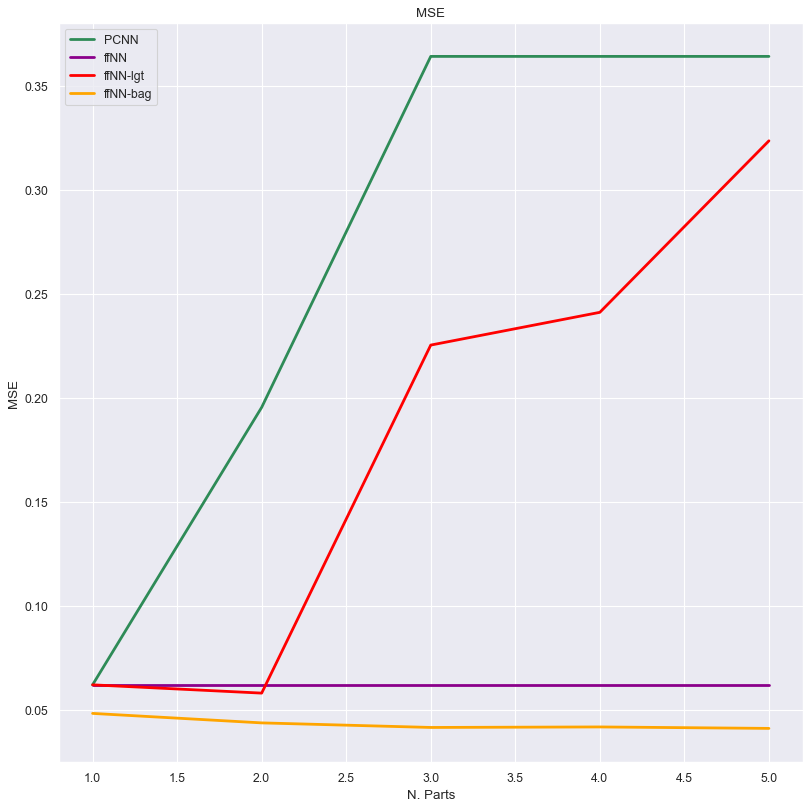

In [45]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MSE")
plt.xlabel("N. Parts")
plt.ylabel("MSE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MSE_test,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MSE_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_lgt_ffNN_report_MSE_test,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_PCNN_ffNN_bag_report_MSE_test,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)
# Add Legend
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_MSE_test___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## MAE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


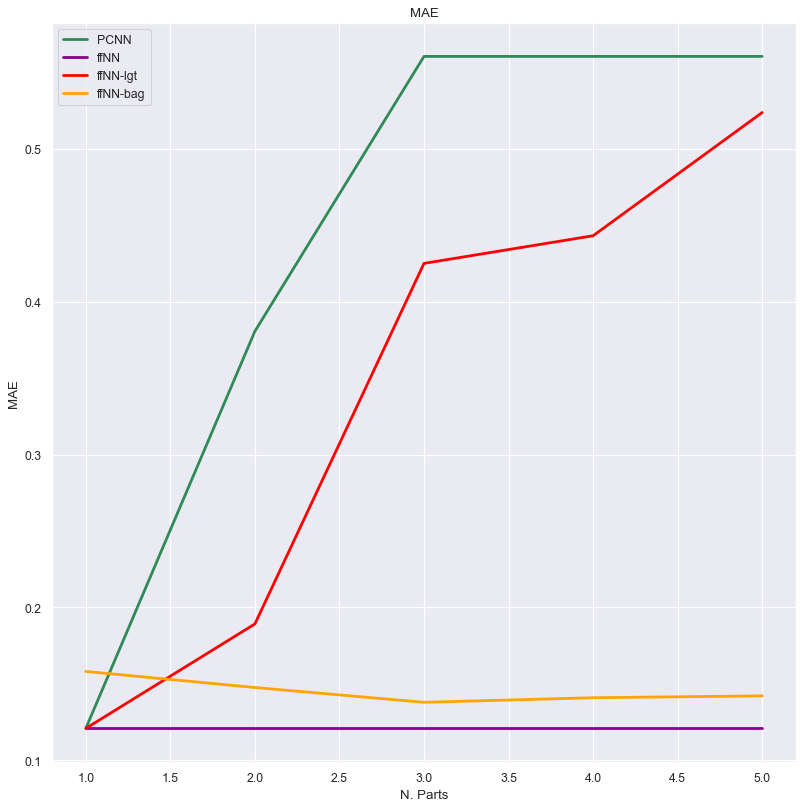

In [46]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MAE")
plt.xlabel("N. Parts")
plt.ylabel("MAE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MAE_test,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MAE_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_lgt_ffNN_report_MAE_test,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_PCNN_ffNN_bag_report_MAE_test,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)

# Export #
#--------#
# SAVE Figure to .eps
plt.legend(loc="upper left")
plt.savefig('./outputs/plotsANDfigures/Ablation_MAE___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# L-Time

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


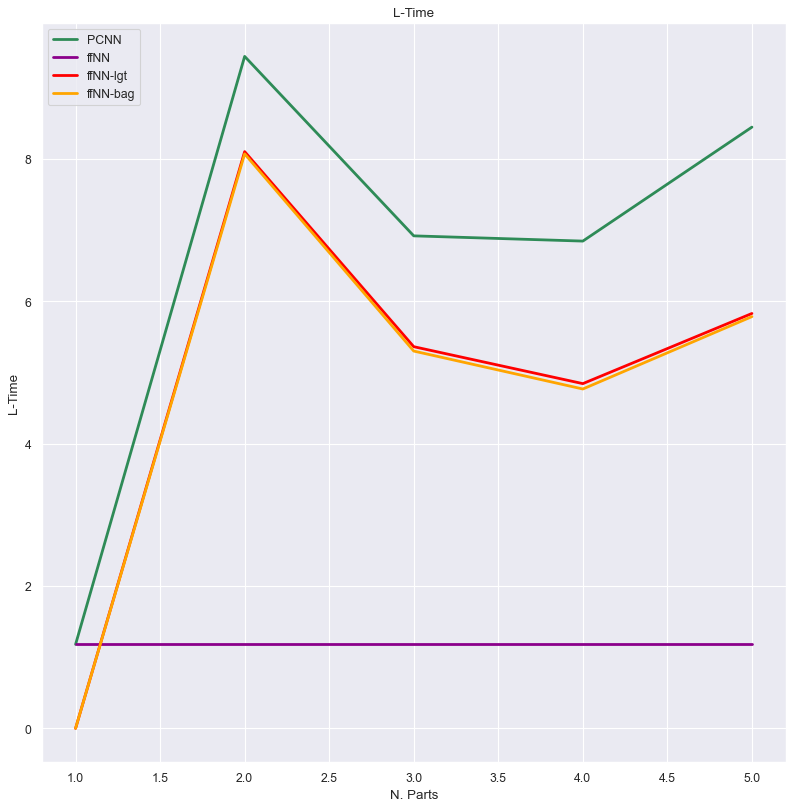

In [56]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("L-Time")
plt.xlabel("N. Parts")
plt.ylabel("L-Time")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_Times,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_time_PCNN_lgt,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_time_PCNN_bag,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_L_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# P-Times

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


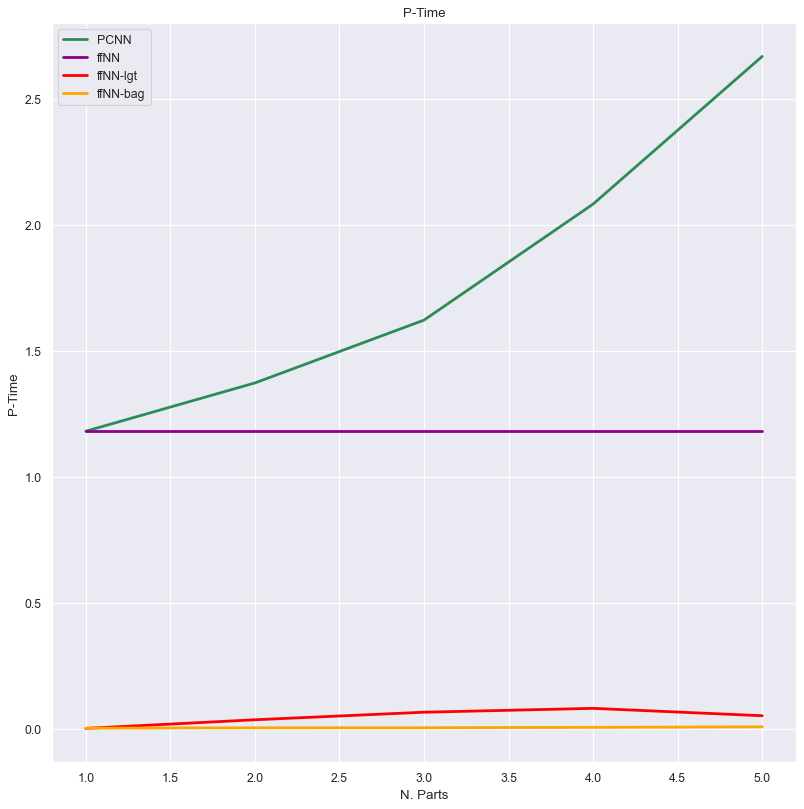

In [57]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("P-Time")
plt.xlabel("N. Parts")
plt.ylabel("P-Time")

# Generate Plots #
#----------------#
# Plot Signal
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_Times,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_time_PCNN_lgt,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_time_PCNN_bag,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_P_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## N-Params

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


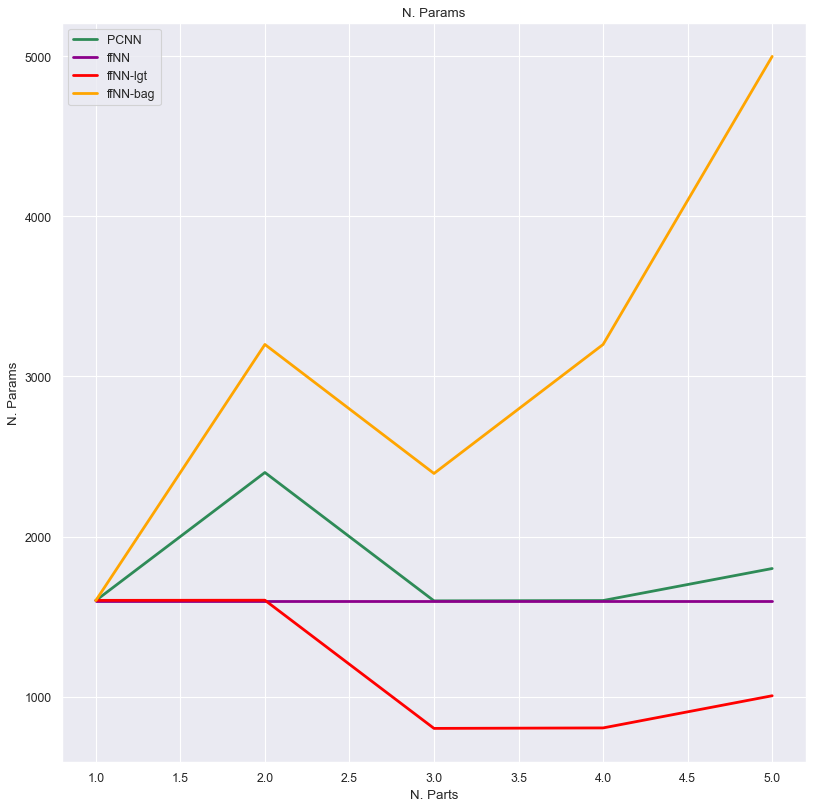

In [49]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("N. Params")
plt.xlabel("N. Parts")
plt.ylabel("N. Params")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_Params,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_params_PCNN_logistic_hist,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_params_PCNN_ffNN_bag,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_N_Params___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Number of Active Neurons Per Input

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


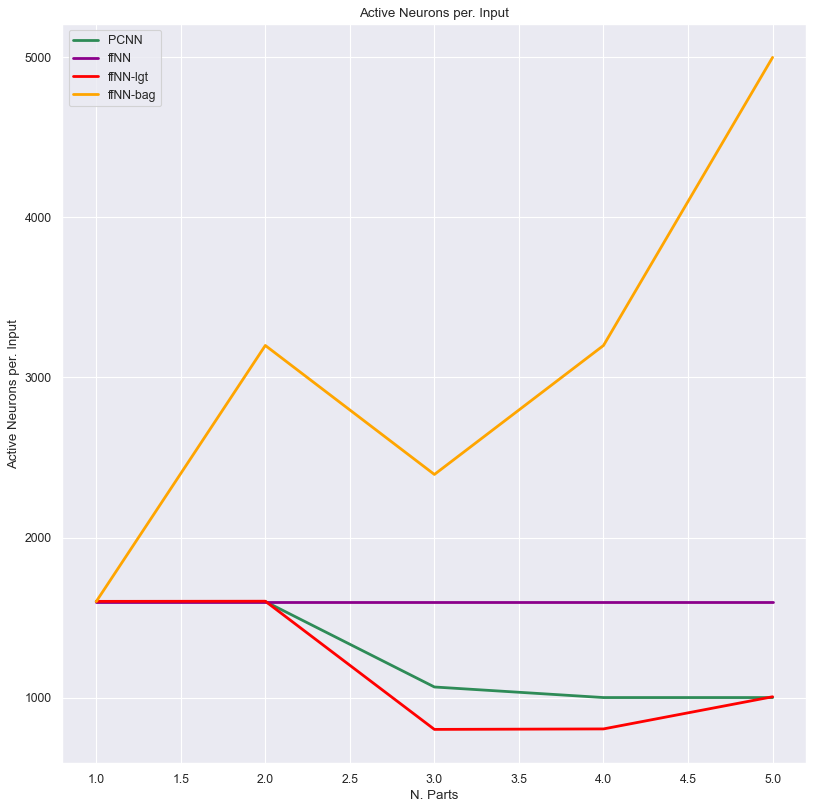

In [50]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Active Neurons per. Input")
plt.xlabel("N. Parts")
plt.ylabel("Active Neurons per. Input")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_per_input,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_params_PCNN_logistic_hist_per_input,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_params_PCNN_ffNN_bag_per_input,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Active_Neurons_per_input___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Mean Widths for Sub-Pattern Networks

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


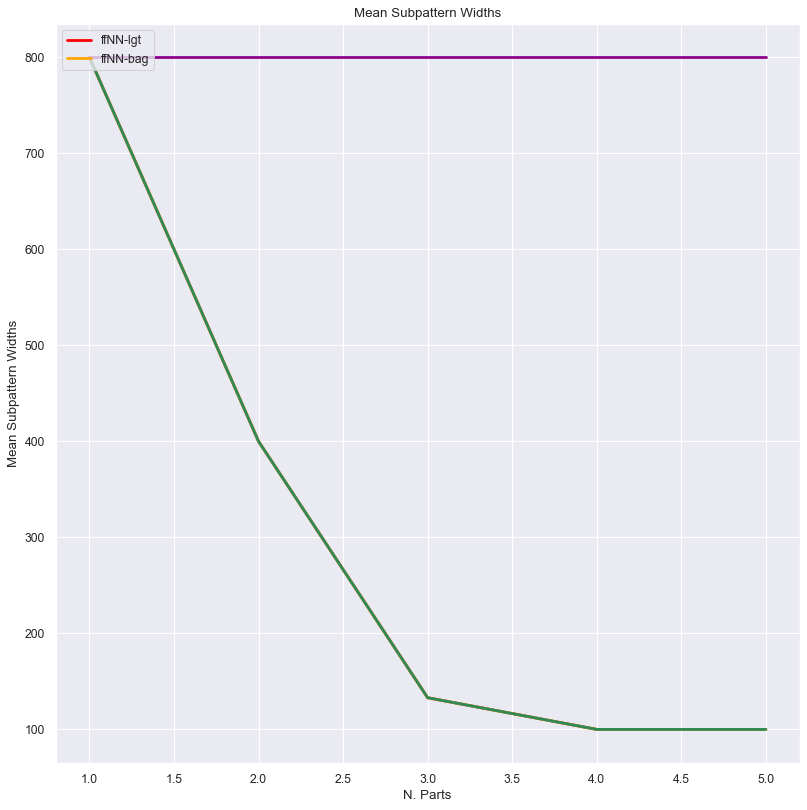

In [55]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Mean Subpattern Widths")
plt.xlabel("N. Parts")
plt.ylabel("Mean Subpattern Widths")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         mean_subpattern_widths_hist,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         mean_subpattern_widths_hist,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)
plt.legend(loc="upper left")
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         mean_subpattern_widths_hist,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         Width_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Mean_Widths___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Table(s)

In [52]:
for j in range(3):
    print('---------------------')
print('Prediction Metric(s)')
for j in range(3):
    print('---------------------')
print(predictive_performance_training)
for j in range(3):
    print(' ')
for j in range(3):
    print('---------------------')
print('Model Complexitie(s)')
for j in range(3):
    print('---------------------')
print(training_times_In_Line)
print(training_times_Parallel)

---------------------
---------------------
---------------------
Prediction Metric(s)
---------------------
---------------------
---------------------
               MAE       MSE       MAPE
ffNN      0.114153  0.057397  16.179025
GBRF      0.114654  0.018530  22.799543
ffNN-bag  0.151870  0.045333  25.925732
ffNN-lgt  0.114153  0.057397  16.179025
PCNN      0.114153  0.057397  16.179025
 
 
 
---------------------
---------------------
---------------------
Model Complexitie(s)
---------------------
---------------------
---------------------
                  ffNN   GBRF  ffNN-Bag  ffNN-log  PCNN
In-Line (L-Time)  1.18  0.579     0.002     0.001  1.18
                  ffNN GBRF  ffNN-Bag  ffNN-log  PCNN
Parallel (P-Time)    -    -     0.002     0.001  1.18


---

---

---

# Fin

---

---

---